# Прогнозирование заказов такси

## Задача

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
Значение метрики **RMSE** на тестовой выборке должно быть **не больше 48**.

Условия:
- **ресемплирование** выполнить **по одному часу**,
- **тестовая выборка размером 10% от исходных данных**.

## Подключаемые библиотеки

In [1]:
!pip install phik -q

In [2]:
!pip install catboost -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import seaborn as sns

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.svm import SVR
from catboost import CatBoostRegressor

In [5]:
RANDOM_STATE = 42

## Исходные данные

In [6]:
try:
    taxi = pd.read_csv('taxi.csv', parse_dates=[0])
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0])

In [7]:
taxi.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


## Подготовка данных

In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [9]:
taxi.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [10]:
taxi.duplicated().sum()

0

In [11]:
taxi = taxi.set_index('datetime')

In [12]:
taxi = taxi.sort_index()

In [13]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Исследовательский анализ данных

### Признак "num_orders"

In [14]:
taxi = taxi.resample('1H').sum()
taxi.head(5)

C:\Users\Marat\AppData\Local\Temp\ipykernel_19424\2772297860.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  taxi = taxi.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [15]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В датафрейме присутствуют часы, за которые не было заказов

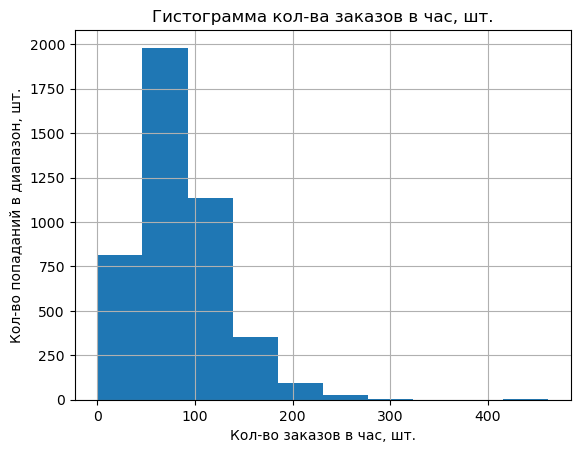

In [16]:
taxi.hist()
plt.ylabel('Кол-во попаданий в диапазон, шт.')
plt.xlabel('Кол-во заказов в час, шт.')
plt.title('Гистограмма кол-ва заказов в час, шт.')
plt.show()

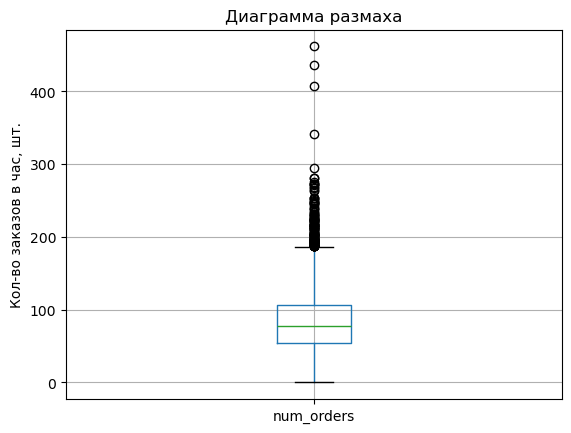

In [17]:
taxi.boxplot()
plt.ylabel('Кол-во заказов в час, шт.')
plt.title('Диаграмма размаха')
plt.show()

В среднем за час поступает 84 заявки, выбросы, скорее всего, связаны с праздниками

Вычислим значение правого "уса"

In [18]:
r_border = taxi.describe().loc['75%'] + (taxi.describe().loc['75%'] - taxi.describe().loc['25%']) * 1.5
r_border

num_orders    186.5
dtype: float64

In [19]:
taxi.index.year.unique()

Index([2018], dtype='int32', name='datetime')

В датафрейме представлены данные только за 2018 год

Исследуем датафрейм на тренды и сезонность

In [20]:
decomposed = seasonal_decompose(taxi)

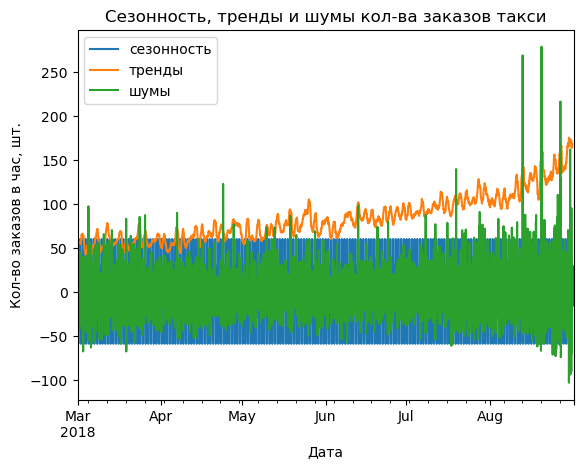

In [21]:
decomposed.seasonal.plot()
decomposed.trend.plot()
decomposed.resid.plot()
plt.legend(labels=['сезонность', 'тренды', 'шумы'])
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов в час, шт.')
plt.title('Сезонность, тренды и шумы кол-ва заказов такси')
plt.show()

Есть явный тренд на увеличение кол-ва заказов такси. Сезонность тоже есть, но надо взять меньший временной интервал

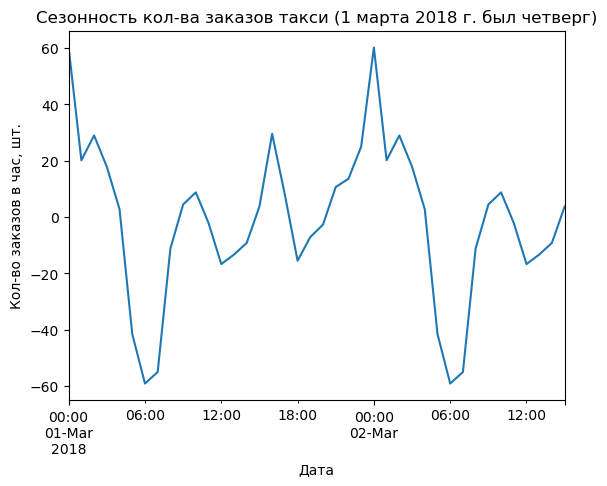

In [22]:
decomposed.seasonal.head(40).plot()
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов в час, шт.')
plt.title('Сезонность кол-ва заказов такси (1 марта 2018 г. был четверг)')
plt.show()

Можно выявить следующую сезонность:
- с 18:00 до 24:00 люди спешат домой,
- до 06:00 тишина (все спят),
- после 06:00 все спешат на работу,
- пик в районе 16:00 скорее всего связан с забором детей из детских садов и школ.

### Признак "hours"

Добавим новый признак 'hours'

In [23]:
taxi['hours'] = taxi.index.hour
taxi.head(5)

,num_orders,hours
datetime,,
2018-03-01 00:00:00,124,0
2018-03-01 01:00:00,85,1
2018-03-01 02:00:00,71,2
2018-03-01 03:00:00,66,3
2018-03-01 04:00:00,43,4


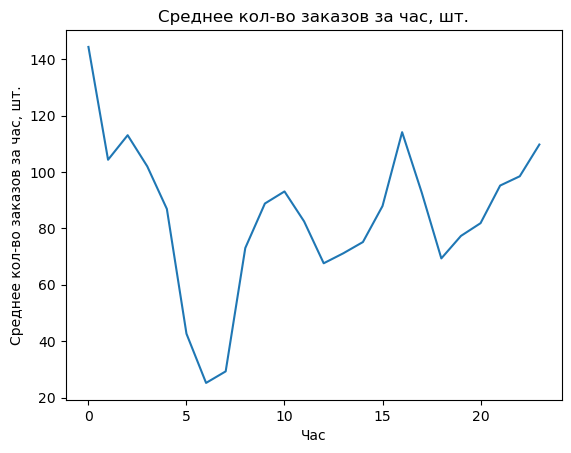

In [24]:
taxi.groupby(by='hours').mean().plot(legend=False)
plt.xlabel('Час')
plt.ylabel('Среднее кол-во заказов за час, шт.')
plt.title('Среднее кол-во заказов за час, шт.')
plt.show()

Получили график сезонности, прослеживается явная связь между кол-вом заказов и часом

### Признак "months"

Добавим новый признак 'months'

In [25]:
taxi['months'] = taxi.index.month
taxi.head(5)

,num_orders,hours,months
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3


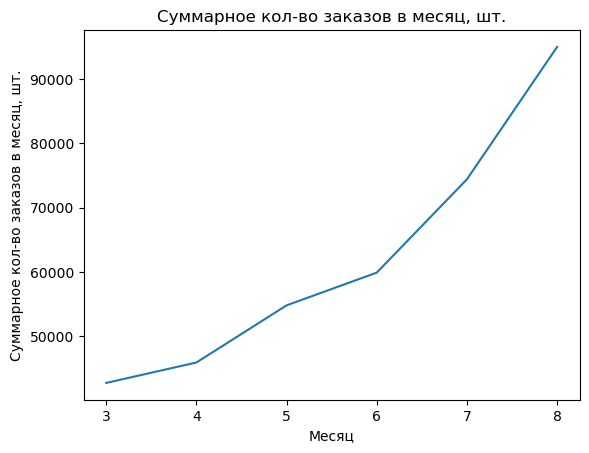

In [26]:
taxi.groupby(by='months').sum()['num_orders'].plot(legend=False)
plt.xlabel('Месяц')
plt.ylabel('Суммарное кол-во заказов в месяц, шт.')
plt.title('Суммарное кол-во заказов в месяц, шт.')
plt.show()

Видно, что при росте номера месяца растет и кол-во заказов

### Признак "dayofweek"

Добавим новый признак 'dayofweek'

In [27]:
taxi['dayofweek'] = taxi.index.dayofweek
taxi.head(5)

,num_orders,hours,months,dayofweek
datetime,,,,
2018-03-01 00:00:00,124,0,3,3
2018-03-01 01:00:00,85,1,3,3
2018-03-01 02:00:00,71,2,3,3
2018-03-01 03:00:00,66,3,3,3
2018-03-01 04:00:00,43,4,3,3


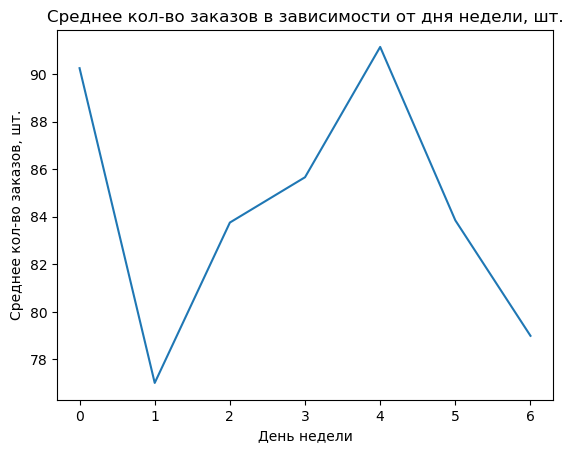

In [28]:
taxi.groupby(by='dayofweek').mean()['num_orders'].plot(legend=False)
plt.xlabel('День недели')
plt.ylabel('Среднее кол-во заказов, шт.')
plt.title('Среднее кол-во заказов в зависимости от дня недели, шт.')
plt.show()

Прослеживается зависимость между днем недели и кол-вом заказов:
- в понедельник (0) пик, так как многие опаздывают после выходных,
- в пятницу (4) пик, так как многие едут отдыхать,
- в воскресенье затишье, так как все сидят по домам

### Признак "shift_1"

Добавим новый признак 'shift_1'

In [29]:
taxi['shift_1'] = taxi['num_orders'].shift()

In [30]:
taxi.head(5)

,num_orders,hours,months,dayofweek,shift_1
datetime,,,,,
2018-03-01 00:00:00,124,0,3,3,NaN
2018-03-01 01:00:00,85,1,3,3,124.0
2018-03-01 02:00:00,71,2,3,3,85.0
2018-03-01 03:00:00,66,3,3,3,71.0
2018-03-01 04:00:00,43,4,3,3,66.0


### Признак "shift_2"

Добавим новый признак 'shift_2'

In [31]:
taxi['shift_2'] = taxi['num_orders'].shift(2)

In [32]:
taxi.head(5)

,num_orders,hours,months,dayofweek,shift_1,shift_2
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,3,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,124.0,NaN
2018-03-01 02:00:00,71,2,3,3,85.0,124.0
2018-03-01 03:00:00,66,3,3,3,71.0,85.0
2018-03-01 04:00:00,43,4,3,3,66.0,71.0


### Признак "shift_3"

Добавим новый признак 'shift_3'

In [33]:
taxi['shift_3'] = taxi['num_orders'].shift(3)

In [34]:
taxi.head(5)

,num_orders,hours,months,dayofweek,shift_1,shift_2,shift_3
datetime,,,,,,,
2018-03-01 00:00:00,124,0,3,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0
2018-03-01 04:00:00,43,4,3,3,66.0,71.0,85.0


### Признак "rolling_mean"

Добавим новый признак 'rolling_mean'

In [35]:
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(8).mean()

In [36]:
taxi.head(5)

,num_orders,hours,months,dayofweek,shift_1,shift_2,shift_3,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,0,3,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,4,3,3,66.0,71.0,85.0,NaN


### Анализ корреляции

In [37]:
map = taxi.phik_matrix(interval_cols=['rolling_mean'])

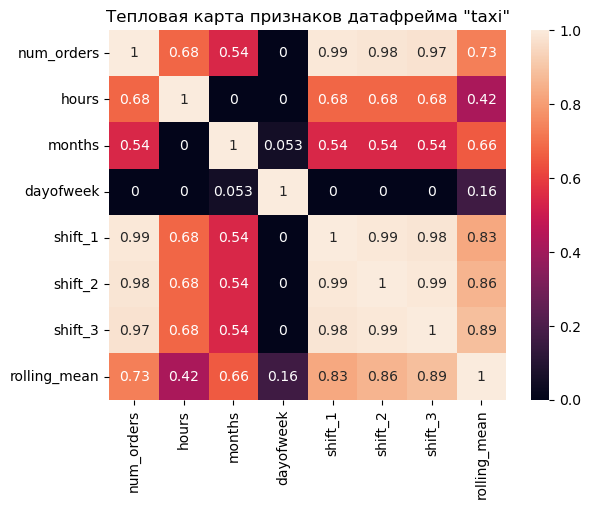

In [38]:
sns.heatmap(map, annot=True)
plt.title('Тепловая карта признаков датафрейма "taxi"')
plt.show()

## Построение модели

In [39]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()
train.head(5)

,num_orders,hours,months,dayofweek,shift_1,shift_2,shift_3,rolling_mean
datetime,,,,,,,,
2018-03-01 08:00:00,34,8,3,3,15.0,12.0,6.0,52.750
2018-03-01 09:00:00,69,9,3,3,34.0,15.0,12.0,41.500
2018-03-01 10:00:00,64,10,3,3,69.0,34.0,15.0,39.500
2018-03-01 11:00:00,96,11,3,3,64.0,69.0,34.0,38.625
2018-03-01 12:00:00,30,12,3,3,96.0,64.0,69.0,42.375


In [40]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [41]:
num_columns = ['hours', 'months', 'dayofweek', 'shift_1', 'shift_2', 'shift_3', 'rolling_mean']

In [42]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [43]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [44]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [SVR()],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [45]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

In [46]:
grid_search.fit(X_train, y_train)

Learning rate set to 0.0509
0:	learn: 37.6211302	total: 145ms	remaining: 2m 25s
1:	learn: 36.7936330	total: 147ms	remaining: 1m 13s
2:	learn: 35.9292804	total: 148ms	remaining: 49.1s
3:	learn: 35.2006142	total: 149ms	remaining: 37.1s
4:	learn: 34.4335032	total: 150ms	remaining: 29.9s
5:	learn: 33.7282759	total: 151ms	remaining: 25.1s
6:	learn: 33.1492130	total: 152ms	remaining: 21.6s
7:	learn: 32.5193822	total: 154ms	remaining: 19s
8:	learn: 31.9399873	total: 155ms	remaining: 17s
9:	learn: 31.3958420	total: 156ms	remaining: 15.4s
10:	learn: 30.8899941	total: 157ms	remaining: 14.1s
11:	learn: 30.4476316	total: 158ms	remaining: 13s
12:	learn: 30.0837238	total: 159ms	remaining: 12.1s
13:	learn: 29.6874735	total: 160ms	remaining: 11.3s
14:	learn: 29.3076810	total: 162ms	remaining: 10.6s
15:	learn: 28.9609748	total: 163ms	remaining: 10s
16:	learn: 28.6534941	total: 164ms	remaining: 9.47s
17:	learn: 28.4069649	total: 165ms	remaining: 9s
18:	learn: 28.1487127	total: 166ms	remaining: 8.58s
19:

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['hours',
                                                                          'months',
                                                                          'dayofweek',
                                                                          'shift_1',
                                                                          'shift_2',
                                                                          'shift_3',
                                                                          'rolling_mean'])])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__m...
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(random_state=42)],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [<catboost.core.CatBoostRegressor object at 0x0000025F1AF39820>],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [47]:
predicts = grid_search.predict(X_test)

In [48]:
rmse = mean_squared_error(y_test, predicts, squared=False)

C:\Users\Marat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [49]:
print('Значение метрики RMSE на тестовой выборке', rmse)

Значение метрики RMSE на тестовой выборке 46.44129027826966


## Вывод

Добиться нужного значения метрики удалось только при CatBoostRegressor

**Вопросы:**
1) почему модели очень чувствительны к значению у rolling. Например, при изменении окна с 7 на 8, метрика может измениться на 10 процентов. Можно ли считать такие колебания устойчивой моделью?